In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

import warnings
warnings.filterwarnings('ignore')

In [91]:
## reproducibility
import os
import random
import tensorflow as tf

seed=71

def seedEvery(seed):
    os.environ['PYTHONHASHSEED']=str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seedEvery(seed)

In [92]:
rawTrain=pd.read_csv('/kaggle/input/titanic/train.csv')
rawTest=pd.read_csv('/kaggle/input/titanic/test.csv')
submit=pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

train=rawTrain.copy()
test=rawTest.copy()

In [93]:
def datainfo(df):
    return pd.DataFrame([(col,df[col].dtype,df[col].nunique(),df[col].isna().sum(),df[col].unique()[:5]) for col in df.columns],
                       columns=['name','dtype','nunique','missing','value :5'])

In [94]:
## data browse
datainfo(train)

## passengerId 필요없다. 후에 test의 submit에만 필요.
## survived를 예측.
## Age, Cabin 결측값, Embarked
## Ticket 종류가 많은데 규칙이 없을까

,name,dtype,nunique,missing,value :5
0,PassengerId,int64,891,0,"[1, 2, 3, 4, 5]"
1,Survived,int64,2,0,"[0, 1]"
2,Pclass,int64,3,0,"[3, 1, 2]"
3,Name,object,891,0,"[Braund, Mr. Owen Harris, Cumings, Mrs. John B..."
4,Sex,object,2,0,"[male, female]"
5,Age,float64,88,177,"[22.0, 38.0, 26.0, 35.0, nan]"
6,SibSp,int64,7,0,"[1, 0, 3, 4, 2]"
7,Parch,int64,7,0,"[0, 1, 2, 5, 3]"
8,Ticket,object,681,0,"[A/5 21171, PC 17599, STON/O2. 3101282, 113803..."
9,Fare,float64,248,0,"[7.25, 71.2833, 7.925, 53.1, 8.05]"


In [95]:
datainfo(test)

,name,dtype,nunique,missing,value :5
0,PassengerId,int64,418,0,"[892, 893, 894, 895, 896]"
1,Pclass,int64,3,0,"[3, 2, 1]"
2,Name,object,418,0,"[Kelly, Mr. James, Wilkes, Mrs. James (Ellen N..."
3,Sex,object,2,0,"[male, female]"
4,Age,float64,79,86,"[34.5, 47.0, 62.0, 27.0, 22.0]"
5,SibSp,int64,7,0,"[0, 1, 2, 3, 4]"
6,Parch,int64,8,0,"[0, 1, 3, 2, 4]"
7,Ticket,object,363,0,"[330911, 363272, 240276, 315154, 3101298]"
8,Fare,float64,169,1,"[7.8292, 7.0, 9.6875, 8.6625, 12.2875]"
9,Cabin,object,76,327,"[nan, B45, E31, B57 B59 B63 B66, B36]"


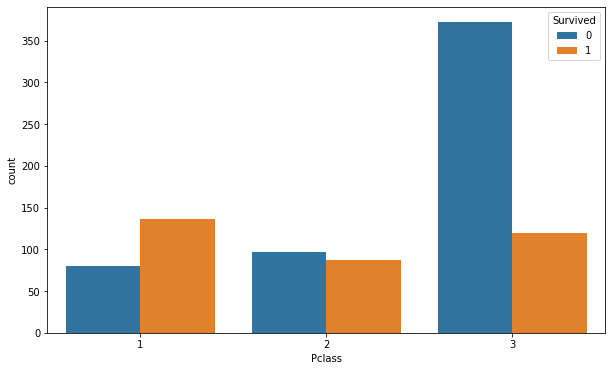

In [96]:
## eda

## Pclass 3일수록 많이 죽었고, 1은 거의 살았다. 
fig,ax=plt.subplots(1,1,figsize=(10,6))

sns.countplot(x="Pclass",hue="Survived",data=train,ax=ax)
plt.show()

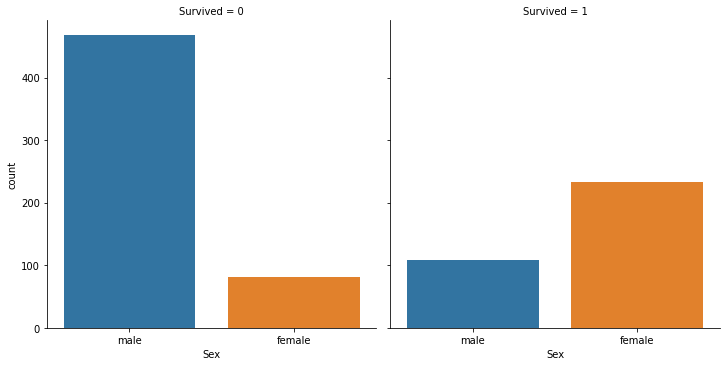

In [97]:
## 남자가 많이 죽었다.
sns.catplot(x='Sex',col='Survived',data=train,kind='count')
plt.show()

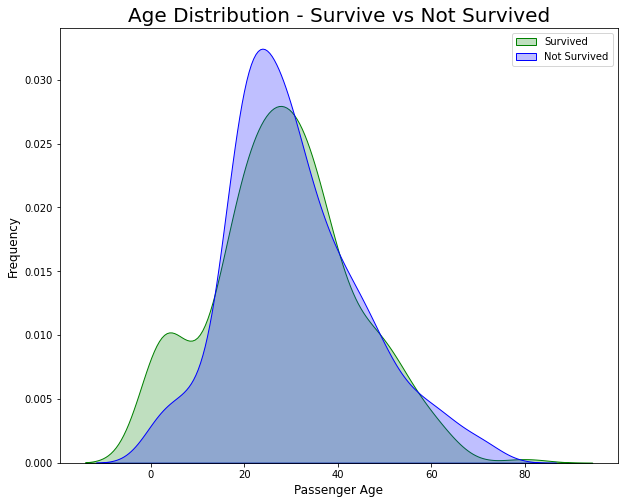

In [98]:
## 나이가 어리고, 젊은 사람이 많이 살았다.
## 더 죽었다.
fig,ax=plt.subplots(1,1,figsize=(10,8))
sns.kdeplot(train.loc[(train['Survived']==1),'Age'],color='g',shade=True,label='Survived',ax=ax)
sns.kdeplot(train.loc[(train['Survived']==0),'Age'],color='b',shade=True,label='Not Survived',ax=ax)
ax.set_title('Age Distribution - Survive vs Not Survived',fontsize=20)
ax.set_xlabel("Passenger Age",fontsize=12)
ax.set_ylabel('Frequency', fontsize = 12)
ax.legend()
plt.show()

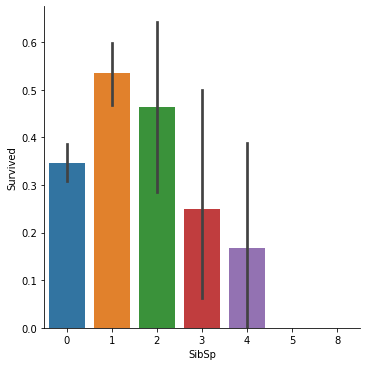

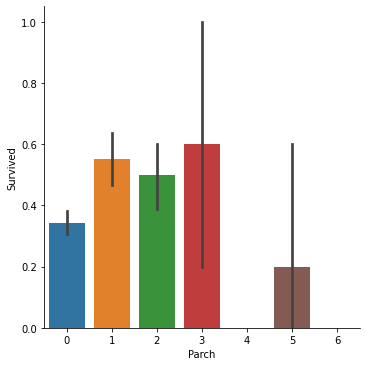

In [99]:
## SipSp는 배우자나 형제 자매 명 수의 총 합,즉 1,2명일때 많이 살아남았다.
## Parch는 부모 자식 명 수의 총 합, 즉 3명일때 많이 살아남았다.

sns.factorplot(x='SibSp',y='Survived',data=train,kind='bar')
sns.factorplot(x='Parch',y='Survived',data=train,kind='bar')

plt.show()

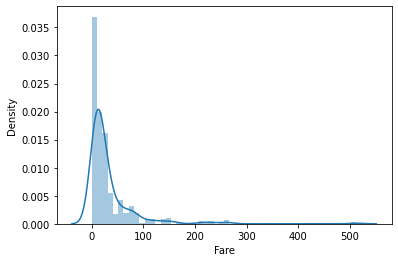

In [100]:
## Fare의 분포 이것만 봐서는 모르겠다. 
sns.distplot(train['Fare']);

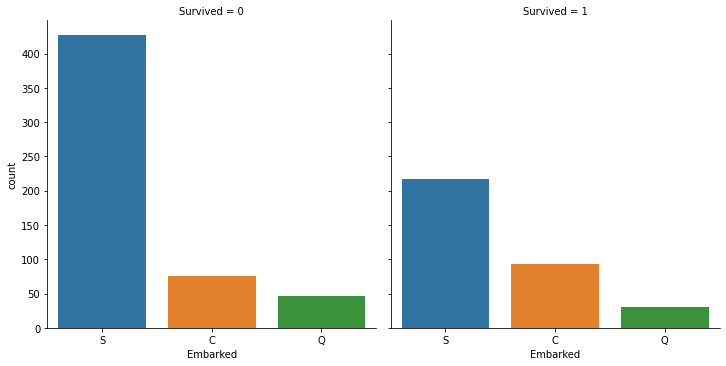

In [101]:
## embarked에 따라 크게 차이가 있어보이진 않는다.
sns.catplot(x="Embarked",col="Survived",data=train,kind='count')

In [102]:
## feature engineering 

train=rawTrain.copy()
test=rawTest.copy()

train['iftrain']=1
test['iftrain']=0
Data=pd.concat([train,test],ignore_index=True)

train.shape,test.shape,Data.shape

((891, 13), (418, 12), (1309, 13))

In [103]:
## drop passengerId
Data=Data.drop(['PassengerId'],axis=1)

In [104]:
## name 
## 이름을 통해 성별을 유추할 수 있다고 생각했다. 

Data['title']=Data['Name'].map(lambda x:x.split(',')[1].split('.')[0].strip())

In [105]:
## Data.groupby(['Title'])['Age'].mean()
## 그러던 중 Master는 나이가 어린 사람에게 쓰는것 같다고 생각했다. 
## 또, Data.groupby(['Title'])['Survived'].mean() 을 했을 때 약 55%나 살았다. 

## 이름은 4개의 카테고리로 나누기로 했다.

Data['title']=Data['title'].replace('Mlle','Miss')
Data['title']=Data['title'].replace(['Mme','Lady','Ms'],'Mrs')
Data['title'].loc[(Data['title']!='Master')&(Data['title']!='Mr')&
                  (Data['title']!='Miss')&(Data['title']!='Mrs')]='Others'

In [106]:
## 성별 - 단순 치환
Data['Sex']=Data['Sex'].map({'male':0,'female':1}) 

In [107]:
## SipSp와 Parch를 가족을 대표하는 변수들을 하나로 합친다. 
Data['fsize']=Data['SibSp']+Data['Parch']+1

In [108]:
## 가족이 살아남을 확률은 보통 2명, 그리고 4명 즉, 배우자 및 자녀의 수 합이 2부터 4일때 살아남는 경우가 있다.
## 2부터 4만 따로 묶는다.
def fsizeBand(size):
    if size == 1:
        return 0
    elif size <= 4: 
        return 1
    else:
        return 2
        
Data['fsizeBin']=Data['fsize'].map(fsizeBand)

In [109]:
## Embarked train에만 비어있는 이 값은 이름을 구글에 치면 Southampton 에서 탑승했다는 기록이 있다.
Data['Embarked']=Data['Embarked'].fillna('S')

In [110]:
## Ticket은 앞자리가 같으면 비슷하지 않을까 가정.
## 
Data['TicketHead']=Data['Ticket'].apply(lambda x:x[0])

In [111]:
## Cabin은 결측값이 많아서 채우기보다 버리기로 판단한다.
## 그 외 처리했던 변수들 제거 한다.

Data=Data.drop(['Ticket','Cabin','Name','SibSp','Parch'],axis=1)

In [112]:
## Fare는 testset에 결측값이 있는데 train의 정보로만 판단해야하므로 
## train의 남자,부모형제없고, embarked가 S면서 나이대 비슷한 사람과 연관지어서 값을 넣는다. 
## 가정이다.

Data.loc[Data['Fare'].isna(),'Fare']=6.2375

In [113]:
## Age 결측값 채우기 
## title로 유추 할 수 있다고 가정.
def titleAge(title):
    if title=='Master':
        return 4
    elif title=='Miss':
        return 22
    elif title=='Mr':
        return 29
    elif title=='Mrs':
        return 35
    else:
        return 47
    
Data['Age']=Data.apply(lambda row:titleAge(row['title']) if pd.isnull(row['Age']) else row['Age'],axis=1)

In [114]:
## 마무리
Data=pd.get_dummies(Data,drop_first=True)

In [115]:
## modeling 

train=Data.loc[Data['iftrain']==1]
test=Data.loc[Data['iftrain']==0]
test=test.drop(["Survived"],axis=1)

train=train.drop(['iftrain'],axis=1)
test=test.drop(['iftrain'],axis=1)

In [116]:
from sklearn.preprocessing import StandardScaler

X=train.drop(['Survived'],axis=1).values

sc=StandardScaler()
X=sc.fit_transform(X)
test=sc.transform(test)
y=train['Survived'].values

In [117]:
from keras.layers import Dense
from keras.models import Sequential

ANN=Sequential()
ANN.add(Dense(32,input_dim=27,activation='relu',kernel_initializer=tf.keras.initializers.GlorotNormal()))
ANN.add(Dense(16,activation='relu',kernel_initializer=tf.keras.initializers.GlorotNormal()))
ANN.add(Dense(8,activation='relu',kernel_initializer=tf.keras.initializers.GlorotNormal()))
ANN.add(Dense(4,activation='relu',kernel_initializer=tf.keras.initializers.GlorotNormal()))
ANN.add(Dense(2,activation='relu',kernel_initializer=tf.keras.initializers.GlorotNormal()))
ANN.add(Dense(1,activation='sigmoid'))

ANN.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

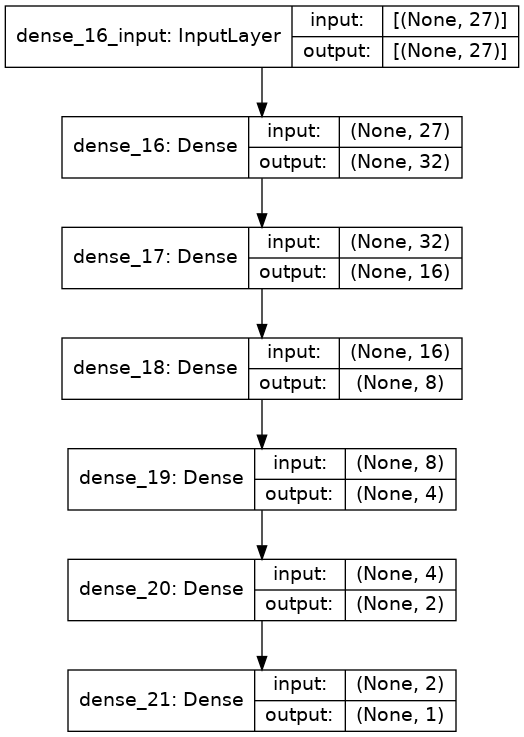

In [118]:
from keras.utils import plot_model

plot_model(ANN,show_shapes=True,show_layer_names=True)

In [119]:
callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='loss',patience=3),
    tf.keras.callbacks.ModelCheckpoint(filepath='/kaggle/working/model.h5',
                                       save_weights_only=True,
                                       monitor='accuracy',
                                       mode='max',
                                       save_best_only=True)
]
history=ANN.fit(X,y,epochs=200,steps_per_epoch=50,callbacks=callbacks)

Epoch 1/200
50/50 [==============================] - 1s 1ms/step - loss: 0.6878 - accuracy: 0.6214
Epoch 2/200
50/50 [==============================] - 0s 1ms/step - loss: 0.6306 - accuracy: 0.6189
Epoch 3/200
50/50 [==============================] - 0s 1ms/step - loss: 0.5326 - accuracy: 0.6070
Epoch 4/200
50/50 [==============================] - 0s 1ms/step - loss: 0.5140 - accuracy: 0.6594
Epoch 5/200
50/50 [==============================] - 0s 1ms/step - loss: 0.5147 - accuracy: 0.7983
Epoch 6/200
50/50 [==============================] - 0s 1ms/step - loss: 0.4871 - accuracy: 0.8353
Epoch 7/200
50/50 [==============================] - 0s 1ms/step - loss: 0.4808 - accuracy: 0.8332
Epoch 8/200
50/50 [==============================] - 0s 1ms/step - loss: 0.4558 - accuracy: 0.8468
Epoch 9/200
50/50 [==============================] - 0s 1ms/step - loss: 0.4669 - accuracy: 0.8381
Epoch 10/200
50/50 [==============================] - 0s 1ms/step - loss: 0.4670 - accuracy: 0.8262
Epoch 11/

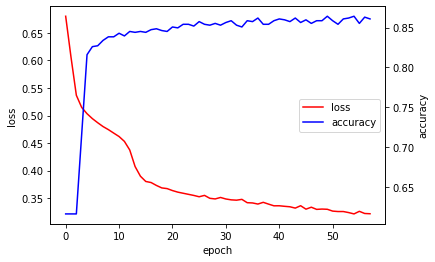

In [120]:
fig,loss_ax=plt.subplots()

line1=loss_ax.plot(history.history['loss'],'r',label='loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

acc_ax=loss_ax.twinx()
line2=acc_ax.plot(history.history['accuracy'],'b',label='accuracy')
acc_ax.set_ylabel('accuracy')

lines=line1+line2
labs=[l.get_label() for l in lines]
loss_ax.legend(lines,labs,loc='right')

plt.show()

In [121]:
ANN.load_weights('/kaggle/working/model.h5')

In [123]:
pred=ANN.predict(test)

res=[]
for i in range(len(pred)):
    if pred[i]<0.5:res.append(0)
    else:res.append(1)

In [124]:
submit['Survived']=res
submit.head()
submit.to_csv('submit.csv',index=False)